# Example: Chlamydia in England, 2012

This example illustrates a method for using chlamydia surveillance data to estimate prevalence. Surveillance data on chlamydia testing and diagnosis rates in England in 2012 were downloaded from: http://www.chlamydiascreening.nhs.uk/ps/data.asp (downloaded 17 April 2015).


|           | Men         |             |       |Women       |             |        |
|-----------|-------------|-------------|-------|------------|-------------|--------|
|           | 15-19 years | 20-24 years | Total |15-19 years | 20-24 years | Total  |
|Population |1685620      | 1833395     |3519015|1600686     |1788156      |3388842 |
|Tests      |232668       | 334240      |566908 |520358      |685538       |1205896 |
|Diagnoses  |15213        | 33174       |48387  |42874       |45227        |88101   |

Data on sexual behaviour from the third National Study of Sexual Attitudes and Lifestyls (Natsal-3) are available from the UK data service: https://www.ukdataservice.ac.uk/ (downloaded 23 September 2015). These were used to infer 95% confidence intervals for the proportions of men and women, aged 16-19 and 20-24, who were sexually active (see the accompanying R script; note that no 15-year-olds were recruited to Natsal-3). These 95% confidence intervals were in turn used to derive beta-distribution priors for the proportion sexually active within each sex and age group.

## Sampling for testing and diagnosis rates

In [1]:
from numpy import *
from scipy.stats import beta
from scipy.optimize import fsolve

######################
# parameters of beta distributions representing the proportion of the population sexually 
# active, by sex and age group
######################

# men, 16-19
[alpha_m_16_19, beta_m_16_19] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.6747424, 0.741327698),
    [1,1]
    )
# men, 20-24
[alpha_m_20_24, beta_m_20_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8844970, 0.933759842),
    [1,1]
    )
# men, 16-24
[alpha_m_16_24, beta_m_16_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8023836019, 0.843403825),
    [1,1]
    )
# women, 16-19
[alpha_f_16_19, beta_f_16_19] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.6583593, 0.723554878),
    [1,1]
    )
# women, 20-24
[alpha_f_20_24, beta_f_20_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8904135, 0.934417684),
    [1,1]
    )
# women, 16-24
[alpha_f_16_24, beta_f_16_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.7998634469, 0.837979601),
    [1,1]
    )


Next, sample from distributions for the probability of being sexually active, the size of the sexually active population and the testing and diagnosis rates per person per year.

In [2]:
random.seed = 12345

from scipy.stats import gamma
from numpy.random import normal

n_sample = 10000

# sexually-active populations:
p_active_m_16_19 = random.beta(alpha_m_16_19, beta_m_16_19, size=n_sample) # 16-19 yo only
pop_active_m_15_19 = random.binomial(1685620, p_active_m_16_19, size=n_sample)

p_active_m_20_24 = random.beta(alpha_m_20_24, beta_m_20_24, size=n_sample) # 20-24 yo only
pop_active_m_20_24 = random.binomial(1833395, p_active_m_20_24, size=n_sample)

p_active_m_16_24 = random.beta(alpha_m_16_24, beta_m_16_24, size=n_sample) # 16-24 yo only
pop_active_m_15_24 = random.binomial(3519015, p_active_m_16_24, size=n_sample)

p_active_f_16_19 = random.beta(alpha_f_16_19, beta_f_16_19, size=n_sample) # 16-19 yo only
pop_active_f_15_19 = random.binomial(1600686, p_active_f_16_19, size=n_sample)

p_active_f_20_24 = random.beta(alpha_f_20_24, beta_f_20_24, size=n_sample) # 20-24 yo only
pop_active_f_20_24 = random.binomial(1788156, p_active_f_20_24, size=n_sample)

p_active_f_16_24 = random.beta(alpha_f_16_24, beta_f_16_24, size=n_sample) # 16-24 yo only
pop_active_f_15_24 = random.binomial(3388842, p_active_f_16_24, size=n_sample)

# testing and diagnosis rates, per person per year
test_rate_m_15_19 = random.gamma(232668, 1, size=n_sample)/pop_active_m_15_19
test_rate_m_20_24 = random.gamma(334240, 1, size=n_sample)/pop_active_m_20_24
test_rate_m_15_24 = random.gamma(566908, 1, size=n_sample)/pop_active_m_15_24

diag_rate_m_15_19 = random.gamma(15213, 1, size=n_sample)/pop_active_m_15_19
diag_rate_m_20_24 = random.gamma(33174, 1, size=n_sample)/pop_active_m_20_24
diag_rate_m_15_24 = random.gamma(48387, 1, size=n_sample)/pop_active_m_15_24

diag_rate_f_15_19 = random.gamma(42874, 1, size=n_sample)/pop_active_f_15_19
diag_rate_f_20_24 = random.gamma(45227, 1, size=n_sample)/pop_active_f_20_24
diag_rate_f_15_24 = random.gamma(88101, 1, size=n_sample)/pop_active_f_15_24

test_rate_f_15_19 = random.gamma(520358, 1, size=n_sample)/pop_active_f_15_19
test_rate_f_20_24 = random.gamma(685538, 1, size=n_sample)/pop_active_f_20_24
test_rate_f_15_24 = random.gamma(1205896, 1, size=n_sample)/pop_active_f_15_24

In [3]:
print percentile(test_rate_m_15_24,50)
print percentile(diag_rate_m_15_24,50)

0.195662899637
0.016701129455


## Sampling natural history, behavioural and other parameters

Priors for the proportion of incident infections which are asymptomatic and the test performance were taken directly from published studies. The proportion of incident infections which are asymptomatic is not known, so we use estimates of the proportion of _prevalent_ infections asymptomatic. Note that these provide an upper bound because treatment seeking by symptomatic cases will deplete the symptomatic pool.

In [4]:
# proportion of incident infections asymptomatic 
p_asymp_m = random.beta(69 + 1, 78 - 69 + 1, size=n_sample) # McKay et al. Lancet (2003) 88% 
p_asymp_f = random.beta(135 + 1, 26 + 1, size=n_sample) # Kahn et al. Sex Transm Dis (2003) 84% NB numbers taken from text, p656

# test performance
p_true_pos_m = random.beta(32+1, 0+1, size=n_sample) # Horner J. Clin. Microbiol (2005): 32 of 32 infected samples tested +ve
p_false_pos_m = random.beta(2+1, 950+1, size=n_sample) # Horner J. Clin. Microbiol (2005): 2 of 952 uninfected samples tested +ve
p_true_pos_f = random.beta(129+1, 12+1, size=n_sample) # Low Health Technol Assess (2007): 129 of 141 infected samples tested +ve
p_false_pos_f = random.beta(4+1, 2323+1, size=n_sample) # Low Health Technol Assess (2007): 4 of 2327 uninfected samples tested +ve

### Rate of treatment seeking by symptomatic cases
We use a Metropolis-Hastings algorithm to sample for the rate of treatment following onset of symptoms, assuming a constant hazard of treatment beginning with the onset of symptoms. Data consist of the estimated proportion of GUM clinic patients with symptoms whose symptoms had started less than one, 1-2, 2-4, 4-6 and more than 6 weeks previously (Mercer _et al._, _Sex. Transm. Infect._ **83**:400-405; 2007).

|           | Proportion  |                         |
|-----------|-------------|-------------------------|
|           | Estimate    | 95% Confidence Interval |
|< 1 week   |26.7%        | (14.4, 44.2)%           |
|7-13 days  |14.4%        | (6.1, 30.2)%            |
|14-27 days |20.8%        | (13.3, 31.0)%           |
|4-6 weeks  |16.6%        | (8.5, 29.9)%            |
|>6 weeks   |21.5%        | (5.5, 56.4)%            |


In [5]:
# function for calculating likelihood of multinomial data
%run multinomial_pmf.py

In [6]:
# Find beta distributions corresponding to 95% CIs reported in Mercer Sex. Transm. Infect. (2007) (see table above).

from numpy import *
from scipy.stats import beta
from scipy.optimize import fsolve

a = empty(5)
b = empty(5)

# < 1 week
[a[0], b[0]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.144, 0.442),
    [1,1]
    )

# 7-13 days
[a[1], b[1]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.061, 0.302),
    [1,1]
    )

# 14-27 days
[a[2], b[2]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.133, 0.310),
    [1,1]
    )

# 28-41 days
[a[3], b[3]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.085, 0.299),
    [1,1]
    )

# 42 days and over
[a[4], b[4]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.055, 0.564),
    [1,1]
    )


In [7]:
# Metropolis-Hastings to get a sample for rate of treatment

i = 0
att_symp = empty(n_sample+1000) # testing rate per person per year. Allow 1000 extra samples for burn-in
ll = empty(n_sample+1000) # log-likelihood
props = empty([n_sample+1000, 5]) # simulated data, for posterior predictive check
old = 0.04 # starting sample value
new = 0.04 # starting sample value

# simulate probabilities corresponding to data

# proportion expected in each time window
tps = array([0., 7., 14., 28., 42., Inf])
simp_old = exp(-old*tps[:5]) - exp(-old*tps[1:])
simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 0.05) # generate a sample from normal distribution
    
    if new < 0:
        att_symp[i] = old # reject
        ll[i] = -1e10
    else:
        simp_old = exp(-old*tps[:5]) - exp(-old*tps[1:])
        simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

        if sum(simp_new > 0) != len(tps) - 1:
            att_symp[i] = old # reject
            ll[i] = -1e10
        else:
            # simulate probabilities corresponding to the data
            log_ratio = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1)) - sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
    
            if log(random.uniform(0,1)) <  log_ratio:
                att_symp[i] = new # accept
                ll[i] = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1))
                old = new
                acc = acc+1
            else:
                att_symp[i] = old # reject
                ll[i] = sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
    
    props[i] = simp_old
    i = i+1
    
att_symp = att_symp[1000:] # remove burn-in samples
ll = ll[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(att_symp)*365.25
print array(percentile(att_symp, [2.5, 97.5]))*365.25

att_symp = att_symp*365.25 # convert rate from day^-1 to year^-1

0.227363636364
14.1207297826
[  8.45955859  22.34811948]


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


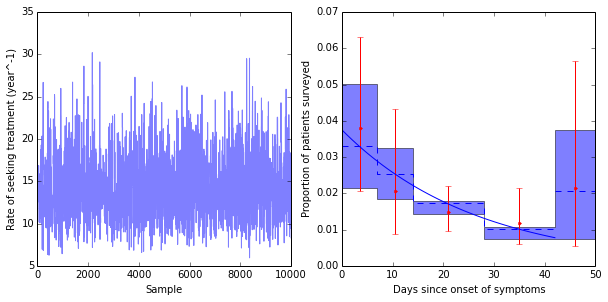

In [8]:
# diagnostics and posterior predictive checks

import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import multinomial

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
ax1.plot(att_symp, alpha=0.5)

ax2 = fig.add_subplot(222)
    
ax2.plot(range(43),median(att_symp/365.25)*exp(-median(att_symp/365.25)*array(range(43))),'b')
#plt.plot(range(50),percentile(att_symp, 2.5)*exp(-percentile(att_symp, 2.5)*array(range(50))),'b--')
#plt.plot(range(50),percentile(att_symp, 97.5)*exp(-percentile(att_symp, 97.5)*array(range(50))),'b--')

#ax2.set_ylim([0,0.1])
ax2.set_xlim([0,50])
ax2.errorbar([3.5,10.5,21,35, 46],
            [0.267/7, 0.144/7, 0.208/14, 0.166/14, 0.215/10],
            abs(array([[0.144/7, 0.061/7, 0.133/14, 0.085/14, 0.055/10],
                       [0.442/7, 0.302/7, 0.310/14, 0.299/14, 0.564/10]]
                      ) - array([0.267/7, 0.144/7, 0.208/14, 0.166/14, 0.215/10])
    ), color = 'r', fmt='.')

ax2.plot([0,7,7,14,14,28,28,42], repeat(percentile(props[:,:4],50,0)/array([7,7,14,14]),2), 'b--')
ax2.plot([42,50], repeat(percentile(props[:,4],50,0)/array([10]),2), 'b--')
ax2.fill_between(
    [0,7,7,14,14,28,28,42,42,50], 
    repeat(percentile(props,2.5,0)/array([7,7,14,14,10]),2), 
    repeat(percentile(props,97.5,0)/array([7,7,14,14,10]),2),
    alpha=0.5
)

ax1.set_xlabel('Sample')
ax1.set_ylabel('Rate of seeking treatment (year^-1)')
ax2.set_xlabel('Days since onset of symptoms')
ax2.set_ylabel('Proportion of patients surveyed')

ax2.legend(loc=4)

The MCMC chain is illustrated in the left-hand panel, and seems to have converged well. 

The right-hand panel shows the probability density of the time between onset of symptoms and attending the GUM clinic where patients were surveyed, to 42 days (solid blue line). The blue shaded area and dashed line show the central 95% and median of simulated histograms for waiting times to clinic, with bins corresponding to time windows reported in the data. The last bin contains all times longer than six weeks and has been divided by 10 (as opposed to the width of the window) to make it readable. For comparison, red error bars show the reported proportions of patients with treatment-seeking times within each time window (estimate and 95% CI), normalised to be on the same scale as the predictions (blue). The good predictive properties of the model are indicated by the agreement between the data, in red, and the posterior predictions in blue.

### Rate of spontaneous clearance of infection

Use a similar model for spontaneous clearance of infection, with data from Joyner et al. _Sex Transm. Dis._ (2002).

In [9]:
from scipy.stats import binom

# Metropolis-Hastings to get a sample for rate of spontaneous clearance in men
# assuming a constant hazard of recovery

i = 0
sc_m = empty(n_sample+1000) # testing rate per person per year
ll_m = empty(n_sample+1000) # log-likelihood
old = 0.1 # starting sample value

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 5) # generate a sample from normal distribution
    
    if new < 0:
        sc_m[i] = old # reject
        ll_m[i] = -1e10
    else:
        simp_old = 1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*old/365.25)
        simp_new = 1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*new/365.25)
                
        if sum(simp_new >0) != 5:
            sc_m[i] = old # reject
            ll_m[i] = -1e10
        else:
            # simulate probabilities 
            log_ratio = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_new)) - sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_old))            
            
            if log(random.uniform(0,1)) <  log_ratio: 
                sc_m[i] = new # accept
                ll_m[i] = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_new))
                old = new
                acc = acc+1
            else:
                sc_m[i] = old # reject
                ll_m[i] = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_old))
        
    i = i+1
    
sc_m = sc_m[1000:] # remove burn-in samples
ll_m = ll_m[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(sc_m)
print percentile(sc_m, [2.5, 97.5])

0.358363636364
4.73034288104
[2.0801438276217055, 8.4727999927596453]


In [10]:
# Metropolis-Hastings to get a sample for rate of spontaneous clearance in women
# assuming a constant hazard of recovery

i = 0
sc_f = empty(n_sample+1000) # testing rate per person per year
ll_f = empty(n_sample+1000) # log-likelihood
old = 0.1 # starting sample value

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 5) # generate a sample from normal distribution
    
    if new < 0:
        sc_f[i] = old # reject
        ll_f[i] = -1e10
    else:
        simp_old = 1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*old/365.25)
        simp_new = 1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*new/365.25)
                
        if sum(simp_new >0) != 5:
            sc_f[i] = old # reject
            ll_f[i] = -1e10
        else:
            # simulate probabilities 
            log_ratio = sum(binom.logpmf([2,7,1,0,3], [12,28,4,8,6], simp_new)) - sum(binom.logpmf([2,7,1,0,3], [12,28,4,8,6], simp_old))
            
            if log(random.uniform(0,1)) <  log_ratio: 
                sc_f[i] = new # accept
                ll_f[i] = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_new))
                old = new
                acc = acc+1
            else:
                sc_f[i] = old # reject
                ll_f[i] = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_old))
        
    i = i+1
    
sc_f = sc_f[1000:] # remove burn-in samples
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(sc_f)
print percentile(sc_f, [2.5, 97.5])

0.264545454545
4.14242233987
[2.2314875130683913, 6.8186778331205042]


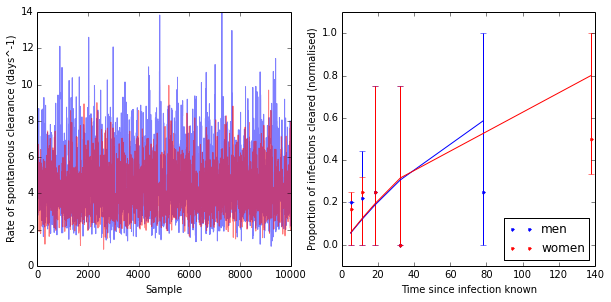

In [11]:
fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
ax1.plot(sc_m, alpha=0.5)
ax1.plot(sc_f, 'r', alpha=0.5)
ax1.set_ylim([0,14])

ax2 = fig.add_subplot(222)

# men
simdat = zeros([n_sample, 5])
for i in xrange(n_sample):
    simp = 1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[i]/365.25)
    simdat[i] = binom.rvs([15,9,4,4,4], simp)
    
men = ax2.plot(
    [5, 11.5, 18.5, 32.5, 78],
    array([3,2,1,0,1])/array([15.,9.,4.,4.,4.]), 
    '.', label='men')
mlm = argmax(ll_m)

ax2.errorbar([5, 11.5, 18.5, 32.5, 78], 
            1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[mlm]/365.25),
            yerr = array([1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[mlm]/365.25) -
                    percentile(simdat, 2.5, 0)/array([15.,9.,4.,4.,4.]),
                    percentile(simdat, 97.5, 0)/array([15.,9.,4.,4.,4.]) -
                    1 + exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[mlm]/365.25)
                    ]),
                    color='b')
# women
simdat = zeros([n_sample, 5])
for i in xrange(n_sample):
    simp = 1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_m[i]/365.25)
    simdat[i] = binom.rvs([12,28,4,8,6], simp)
    
women = ax2.plot(
    [5, 11.5, 18.5, 32.5, 137.5],
    array([2,7,1,0,3])/array([12.,28.,4.,8.,6.]), 
    '.r', label='women')
mlf = argmax(ll_f)

ax2.errorbar([5, 11.5, 18.5, 32.5, 137.5], 
            1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_f[mlf]/365.25),
            yerr = array([1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_f[mlf]/365.25) -
                    percentile(simdat, 2.5, 0)/array([12.,28.,4.,8.,6.]),
                    percentile(simdat, 97.5, 0)/array([12.,28.,4.,8.,6.]) -
                    1 + exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_f[mlf]/365.25)
                    ]),
                    color='r')

ax2.set_ylim([-0.1, 1.1])

ax1.set_xlabel('Sample')
ax1.set_ylabel('Rate of spontaneous clearance (days^-1)')
ax2.set_xlabel('Time since infection known')
ax2.set_ylabel('Proportion of infections cleared (normalised)')

ax2.legend(loc=4)

Again, the chains appear to have converged well (left). In the posterior predictive check (right), point markers show the proportion of patients returning at each time point who had cleared their infection. The solid line and error bars indicate maximum likelihood and 95% of sample predictions, and cover all data points.

## Estimating national prevalence

The sampled parameter values are now used to infer prevalence in men and women in different age groups.

In [12]:
# this script contains the functions for three-part observations (tests, symptomatic diagnoses, asymptomatic diagnoses) too
# running this script takes a little while because of all the symbolic algebra
%run test_diag_fun.py

from numpy import *
from scipy.optimize import fsolve

In [13]:
# men first...
prev_m_15_19 = zeros(n_sample)
inc_m_15_19 = zeros(n_sample)
scr_m_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_15_19[i], scr_m_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_19[i],diag_rate_m_15_19[i]]), [0.09, 0.25])
    prev_m_15_19[i] = dyn_fun(inc_m_15_19[i]*p_asymp_m[i], sc_m[i] + scr_m_15_19[i]*p_true_pos_m[i], inc_m_15_19[i]*(1-p_asymp_m[i]), sc_m[i] + scr_m_15_19[i]*p_true_pos_m[i] + att_symp[i]*p_true_pos_m[i])

In [14]:
prev_m_20_24 = zeros(n_sample)
inc_m_20_24 = zeros(n_sample)
scr_m_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_20_24[i], scr_m_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_20_24[i],diag_rate_m_20_24[i]]), [0.09, 0.25])
    prev_m_20_24[i] = dyn_fun(inc_m_20_24[i]*p_asymp_m[i], sc_m[i] + scr_m_20_24[i]*p_true_pos_m[i], inc_m_20_24[i]*(1-p_asymp_m[i]), sc_m[i] + att_symp[i]*p_true_pos_m[i])

In [15]:
prev_m_15_24 = zeros(n_sample)
inc_m_15_24 = zeros(n_sample)
scr_m_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_15_24[i], scr_m_15_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_24[i],diag_rate_m_15_24[i]]), [0.09, 0.25])
    prev_m_15_24[i] = dyn_fun(inc_m_15_24[i]*p_asymp_m[i], sc_m[i] + scr_m_15_24[i]*p_true_pos_m[i], inc_m_15_24[i]*(1-p_asymp_m[i]), sc_m[i] + scr_m_15_24[i]*p_true_pos_m[i] + att_symp[i]*p_true_pos_m[i])

In [16]:
# ... then women
prev_f_15_19 = zeros(n_sample)
inc_f_15_19 = zeros(n_sample)
scr_f_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_19[i], scr_f_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_19[i],diag_rate_f_15_19[i]]), [0.03, 0.44])
    prev_f_15_19[i] = dyn_fun(inc_f_15_19[i]*p_asymp_f[i], sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i], inc_f_15_19[i]*(1-p_asymp_f[i]), sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i])

In [17]:
prev_f_20_24 = zeros(n_sample)
inc_f_20_24 = zeros(n_sample)
scr_f_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_20_24[i], scr_f_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_20_24[i],diag_rate_f_20_24[i]]), [0.03, 0.44])
    prev_f_20_24[i] = dyn_fun(inc_f_20_24[i]*p_asymp_f[i], sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i], inc_f_20_24[i]*(1-p_asymp_f[i]), sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i])

In [18]:
prev_f_15_24 = zeros(n_sample)
inc_f_15_24 = zeros(n_sample)
scr_f_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_24[i], scr_f_15_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_f_15_24[i]]), [0.03, 0.44])
    prev_f_15_24[i] = dyn_fun(inc_f_15_24[i]*p_asymp_f[i], sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i], inc_f_15_24[i]*(1-p_asymp_f[i]), sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i])

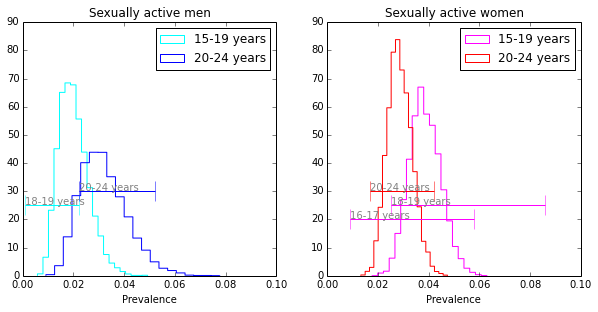

In [19]:
fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
h_2012_m_15_19 = ax1.hist(prev_m_15_19, bins=20, normed=true, histtype='step', color='cyan', label='15-19 years')
h_2012_m_20_24 = ax1.hist(prev_m_20_24, bins=20, normed=true, histtype='step', color='blue', label='20-24 years')
ax1.errorbar(0.001, 25, xerr=[[0],[0.022-0.001]], ecolor='cyan', capsize=10)
ax1.errorbar(0.022, 30, xerr=[[0],[0.052-0.022]], ecolor='blue', capsize=10)
ax1.annotate('18-19 years', [0.001, 25], color='0.5')
ax1.annotate('20-24 years', [0.022, 30], color='0.5')
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.1)
ax1.set_ylim(0,90)
ax1.set_title('Sexually active men')
ax1.legend()

ax2 = fig.add_subplot(222)
h_2012_f_15_19 = ax2.hist(prev_f_15_19, range=[min(prev_f_15_19),max(prev_f_15_19)], bins=20, normed=true, histtype='step', color='fuchsia', label='15-19 years')
h_2012_f_20_24 = ax2.hist(prev_f_20_24, range=[min(prev_f_20_24),max(prev_f_20_24)], bins=20, normed=true, histtype='step', color='r', label='20-24 years')
ax2.errorbar(0.009, 20, xerr=[[0],[0.058-0.009]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.025, 25, xerr=[[0],[0.086-0.025]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.017, 30, xerr=[[0],[0.042-0.017]], ecolor='r', capsize=10)
ax2.annotate('16-17 years', [0.009, 20], color='0.5')
ax2.annotate('18-19 years', [0.025, 25], color='0.5')
ax2.annotate('20-24 years', [0.017, 30], color='0.5')
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.1)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women')
ax2.legend()

In these plots, step histograms show the sampled values for prevalence in men and women, by age group. The horizontal bars give 95% confidence intervals for prevalence in comparable age groups, estimated from Natsal-3. They show the agreement between our surveillance-based method and the population-based survey.

95% CI for sexually active men, 15-24 years: 0.0143411089164 0.0444858682479
95% CI for sexually active women, 15-24 years: 0.0225878112061 0.0438780253387


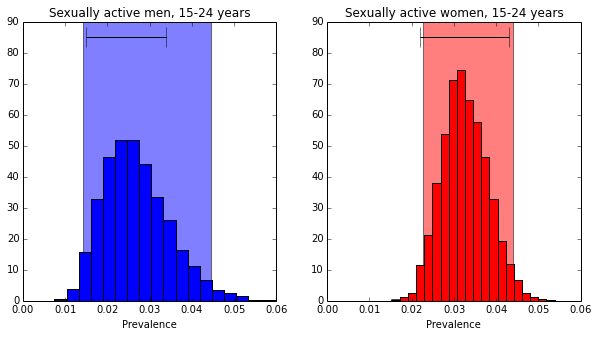

In [23]:
fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(121)
h_2012_m_15_24 = ax1.hist(prev_m_15_24, bins=20, normed=true, color='b')
ax1.fill_betweenx([0,100], percentile(prev_m_15_24, 2.5), percentile(prev_m_15_24, 97.5), facecolor='b', alpha=0.5)
ax1.errorbar(0.015, 85, xerr=[[0],[0.034-0.015]], ecolor='k', capsize=10)
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.06)
ax1.set_ylim(0,90)
ax1.set_title('Sexually active men, 15-24 years')

print '95% CI for sexually active men, 15-24 years:', percentile(prev_m_15_24, 2.5), percentile(prev_m_15_24, 97.5)

ax2 = fig.add_subplot(122)
h_2012_f_15_24 = ax2.hist(prev_f_15_24, range=[min(prev_f_15_24),max(prev_f_15_24)], bins=20, normed=true, color='r')
ax2.fill_betweenx([0,100], percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5), facecolor='r', alpha=0.5)
ax2.errorbar(0.022, 85, xerr=[[0],[0.043-0.022]], ecolor='k', capsize=10)
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.06)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women, 15-24 years')

print '95% CI for sexually active women, 15-24 years:', percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5)

In this figure, histograms again represent sampled prevalence values and horizontal bars the corresponding Natsal-3 estimates. The shaded areas give the 95% credible interval from our samples.

## Symptomatic and asymptomatic diagnoses

Although the data does not report the number of diagnoses that were in symptomatic and asymptomatic cases, we can propose different possible numbers of symptomatic and asymptomatic diagnoses and examine the inferences which would have followed in each case.

In [ ]:
# men first...
prev_m = zeros(n_sample)
inc_m = zeros(n_sample)
scr_m = zeros(n_sample)
p_symp_m = zeros(n_sample)

# there were 48387 diagnoses in men aged 15-24
# don't allow all symptomatic or all asymptomatic - messes with gamma distributions
sample_symp_m = ceil(48386*random.uniform(size = n_sample))
diag_rate_symp_m_15_24 = random.gamma(sample_symp_m, 1, size=n_sample)/pop_active_m_15_24

sample_asymp_m = 48387 - sample_symp_m
diag_rate_asymp_m_15_24 = random.gamma(sample_asymp_m, 1, size=n_sample)/pop_active_m_15_24

for i in xrange(n_sample):
    [inc_m[i], scr_m[i], p_symp_m[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_m[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_24[i],diag_rate_symp_m_15_24[i],diag_rate_asymp_m_15_24[i]]), 
                                               [0.01, 0.3, 0.21])
    prev_m[i] = dyn_fun(
        inc_m[i]*(1-p_symp_m[i]), 
        sc_m[i] + scr_m[i]*p_true_pos_m[i], 
        inc_m[i]*p_symp_m[i], 
        sc_m[i] + scr_m[i]*p_true_pos_m[i] + att_symp[i]*p_true_pos_m[i])

In [ ]:
# ...then women
prev_f = zeros(n_sample)
inc_f = zeros(n_sample)
scr_f = zeros(n_sample)
p_symp_f = zeros(n_sample)

# there were 88101 diagnoses in women aged 15-24
# don't allow all symptomatic or all asymptomatic - messes with gamma distributions
sample_symp_f = ceil(88100*random.uniform(size = n_sample))
diag_rate_symp_f_15_24 = random.gamma(sample_symp_f, 1, size=n_sample)/pop_active_f_15_24

sample_asymp_f = 88101 - sample_symp_f
diag_rate_asymp_f_15_24 = random.gamma(sample_asymp_f, 1, size=n_sample)/pop_active_f_15_24

for i in xrange(n_sample):
    [inc_f[i], scr_f[i], p_symp_f[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_f[i], # rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_symp_f_15_24[i],diag_rate_asymp_f_15_24[i]]), 
                                               [0.01, 0.3, 0.21])
    prev_f[i] = dyn_fun(
        inc_f[i]*(1-p_symp_f[i]), 
        sc_f[i] + scr_f[i]*p_true_pos_f[i], 
        inc_f[i]*p_symp_f[i], 
        sc_f[i] + scr_f[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i])

In [ ]:
fig = plt.figure(figsize = (10,12))

xtk_m = [0, 10000, 20000, 30000, 40000] # x-axis ticks for men
xtk_f = [0, 20000, 40000, 60000, 80000] # x-axis ticks for women

ax1 = fig.add_subplot(421)
ax1.plot(100*sample_symp_m/48387, prev_m, '.', alpha = 0.1)
ax1.fill_between([0,50000], 0.015, 0.034, facecolor='b', alpha=0.3)
ax1.plot([60,60],[0,1],'--b')
ax1.plot([80,80],[0,1],'--b')
ax1.set_xlim([0,100])
ax1.set_ylim([0,0.1])
#ax1.set_xticks(xtk_m)
ax1.set_ylabel('Prevalence')
ax1.set_title('Sexually active men, 15-24 years')

ax2 = fig.add_subplot(422)
ax2.plot(100*sample_symp_f/88101, prev_f, '.r', alpha = 0.1)
ax2.fill_between([0,100000], 0.022, 0.043, facecolor='r', alpha=0.3)
ax2.plot([45,45],[0,1],'--r')
ax2.plot([70,70],[0,1],'--r')
ax2.set_xlim([0,100])
ax2.set_ylim([0,0.1])
#ax2.set_xticks(xtk_f)
ax2.set_title('Sexually active women, 15-24 years')

ax3 = fig.add_subplot(423)
ax3.plot(100*sample_symp_m/48387, inc_m, '.', alpha = 0.1)
ax3.plot([60,60],[0,1.2],'--b')
ax3.plot([80,80],[0,1.2],'--b')
ax3.set_xlim([0,100])
ax3.set_ylim([0,1.2])
#ax3.set_xticks(xtk_m)
ax3.set_ylabel('Incidence')

ax4 = fig.add_subplot(424)
ax4.plot(100*sample_symp_f/88101, inc_f, '.r', alpha = 0.1)
ax4.plot([45,45],[0,1.2],'--r')
ax4.plot([70,70],[0,1.2],'--r')
ax4.set_xlim([0,100])
ax4.set_ylim([0,1.2])
#ax4.set_xticks(xtk_f)

ax5 = fig.add_subplot(425)
ax5.plot(100*sample_symp_m/48387, scr_m, '.', alpha = 0.1)
ax5.plot([60,60],[0,1],'--b')
ax5.plot([80,80],[0,1],'--b')
ax5.set_xlim([0,100])
ax5.set_ylim([0,0.5])
ax5.set_ylabel('Screening')
#ax5.set_xticks(xtk_m)

ax6 = fig.add_subplot(426)
ax6.plot(100*sample_symp_f/88101, scr_f, '.r', alpha = 0.1)
ax6.plot([45,45],[0,1],'--r')
ax6.plot([70,70],[0,1],'--r')
ax6.set_xlim([0,100])
ax6.set_ylim([0,0.5])
#ax6.set_xticks(xtk_f)

ax7 = fig.add_subplot(427)
ax7.plot(100*sample_symp_m/48387, p_symp_m, '.', alpha = 0.1)
ax7.plot([60,60],[0,1],'--b')
ax7.plot([80,80],[0,1],'--b')
ax7.plot([0,100],[0.04,0.04],'--b')
ax7.plot([0,100],[0.25,0.25],'--b')
ax7.set_xlim([0,100])
ax7.set_ylim([0,1])
ax7.set_xlabel('Proportion of diagnoses symptomatic (%)')
ax7.set_ylabel('Proportion of incident infections symptomatic')
#ax7.set_xticks(xtk_m)

ax8 = fig.add_subplot(428)
ax8.plot(100*sample_symp_f/88101, p_symp_f, '.r', alpha = 0.1)
ax8.plot([45,45],[0,1],'--r')
ax8.plot([70,70],[0,1],'--r')
ax8.plot([0,100],[0.06,0.06],'--r')
ax8.plot([0,100],[0.30,0.30],'--r')
ax8.set_xlim([0,100])
ax8.set_ylim([0,1])
ax8.set_xlabel('Proportion of diagnoses symptomatic (%)')
#ax8.set_xticks(xtk_f)


The dashed lines are intended as a guide to the eye, to indicate scenarios roughly compatible with the Natsal-3 prevalence estimates.

The observed chlamydia prevalence in Natsal-3 would be consistent with around 60-80% of diagnoses in men and 45-70% in women being asymptomatic. This estimate in turn would suggest that only 5-25% of incident infections in men and 5-30% in women do not progress to symptoms, or conversely that 75-95% of men and 70-95% do – consistent with the 88% and 84% (means of distributions) used in the model. 

In [ ]:
# plot only the prevalence, for figure in paper

fig = plt.figure(figsize = (10,3))

xtk_m = [0, 10000, 20000, 30000, 40000] # x-axis ticks for men
xtk_f = [0, 20000, 40000, 60000, 80000] # x-axis ticks for women

ax1 = fig.add_subplot(121)
ax1.plot(100*sample_symp_m/48387, prev_m, '.', alpha = 0.1)
ax1.fill_between([0,50000], 0.015, 0.034, facecolor='b', alpha=0.3)
ax1.set_xlim([0,100])
ax1.set_ylim([0,0.1])
ax1.set_xlabel('Proportion of diagnoses symptomatic (%)')
ax1.set_ylabel('Prevalence')

ax2 = fig.add_subplot(122)
ax2.plot(100*sample_symp_f/88101, prev_f, '.r', alpha = 0.1)
ax2.fill_between([0,100000], 0.022, 0.043, facecolor='r', alpha=0.3)
ax2.set_xlim([0,100])
ax2.set_ylim([0,0.1])
ax2.set_xlabel('Proportion of diagnoses symptomatic (%)')
